
 Four different types of fire：type = 0, 1, 2, 3

Distribution of four different types of fire:
fire_type
Agricultural Fire    991374
Marine Fire             786
Other/Wildfire        80953
Volcanic Fire             6
Name: count, dtype: int64

 Number of effective FRP records: 1072841

 FRP statistical summary (according to four types of fire):
                    count   mean  median    std  min     max
fire_type                                                   
Agricultural Fire  991135  18.71    10.6  37.13  1.6  9960.7
Marine Fire           785  20.85    16.1  18.22  4.2   334.6
Other/Wildfire      80915  13.78    10.1  13.47  1.8   573.4
Volcanic Fire           6  25.08    11.6  24.87  7.0    64.0


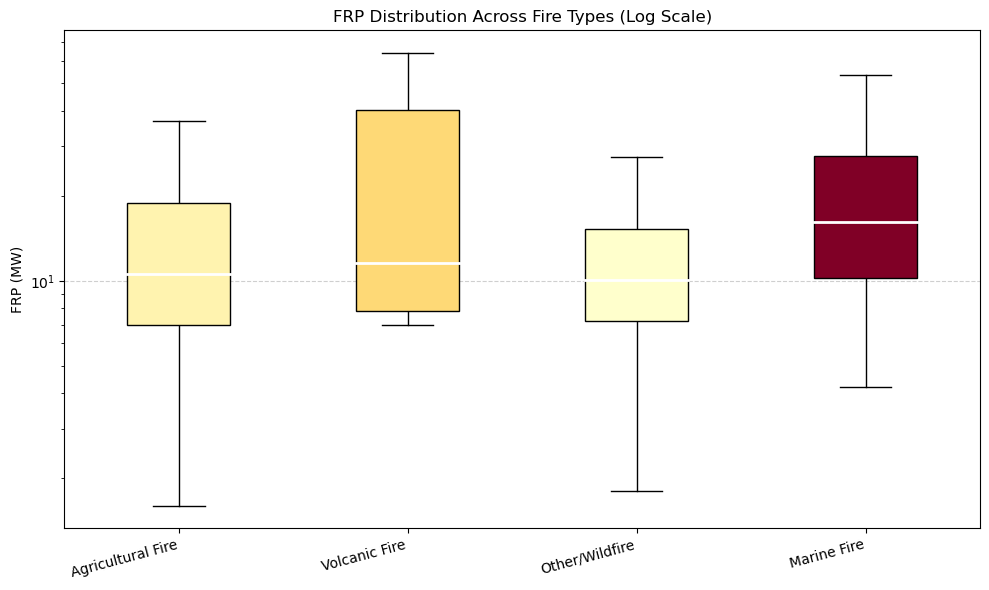


🔬 Kruskal Wallis h test (overall difference of four groups):
  H = 749.77, p = 3.3923e-162
 There are significant differences in FRP of four types of fire (further pairwise comparison is required)

🔍 Pairwise comparison (Mann Whitney U, Bonferroni correction α=0.05/6 ≈ 0.0083)：
  Agricultural Fire vs Volcanic Fire: p = 4.9443e-01 ❌
  Agricultural Fire vs Other/Wildfire: p = 9.9570e-117 ✅
The FRP of Agricultural Fire is significantly higher than that of Other/Wildfire
  Agricultural Fire vs Marine Fire: p = 6.0587e-48 ✅
The FRP of Agricultural Fire is significantly lower than that of Marine Fire
  Volcanic Fire vs Other/Wildfire: p = 4.0345e-01 ❌
  Volcanic Fire vs Marine Fire: p = 6.5905e-01 ❌
  Other/Wildfire vs Marine Fire: p = 1.8421e-78 ✅
The FRP of Other/Wildfire is significantly lower than that of Marine Fire


In [7]:
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats

data_dir = r"C:\Users\komorebi\Desktop\Mini Group Project I Data\Satellite Fire Data"  
pattern = os.path.join(data_dir, "*.csv")
csv_files = glob.glob(pattern)

all_dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    df['filename'] = os.path.basename(file)  
    all_dfs.append(df)

if all_dfs:
    final_df = pd.concat(all_dfs, ignore_index=True)
else:
    final_df = pd.DataFrame()
    
print("\n Four different types of fire：type = 0, 1, 2, 3")

final_df['type'] = pd.to_numeric(final_df['type'], errors='coerce')
df_four = final_df[final_df['type'].isin([0, 1, 2, 3])].copy()

type_labels = {
    0: 'Agricultural Fire',
    1: 'Volcanic Fire',
    2: 'Other/Wildfire',
    3: 'Marine Fire'
}
df_four['fire_type'] = df_four['type'].map(type_labels)

print("\nDistribution of four different types of fire:")
print(df_four['fire_type'].value_counts().sort_index())

df_clean = df_four[df_four['frp'] > 0].copy()
print(f"\n Number of effective FRP records: {len(df_clean)}")

if len(df_clean) == 0:
    raise ValueError("没有有效的 FRP 数据！")


print("\n FRP statistical summary (according to four types of fire):")
summary = df_clean.groupby('fire_type')['frp'].agg(
    count='count',
    mean='mean',
    median='median',
    std='std',
    min='min',
    max='max'
).round(2)
print(summary)

plt.figure(figsize=(10, 6))
df_plot = df_clean.copy()
df_plot['type'] = pd.Categorical(df_plot['type'], categories=[0,1,2,3])
df_plot = df_plot.sort_values('type')


medians = [df_plot[df_plot['type'] == t]['frp'].median() for t in [0,1,2,3]]


norm = plt.Normalize(min(medians), max(medians))
colors = plt.cm.YlOrRd(norm(medians))  # YlOrRd: Yellow-Orange-Red


box_data = [df_plot[df_plot['type'] == t]['frp'] for t in [0,1,2,3]]
labels = [type_labels[t] for t in [0,1,2,3]]

box = plt.boxplot(box_data, 
                 labels=labels, 
                 showfliers=False, 
                 patch_artist=True)

for i, box_patch in enumerate(box['boxes']):
    box_patch.set(facecolor=colors[i])
    box_patch.set(edgecolor='black') 

for median in box['medians']:
    median.set(color='white', linewidth=2)

plt.yscale('log')
plt.ylabel('FRP (MW)')
plt.title('FRP Distribution Across Fire Types (Log Scale)')
plt.xticks(rotation=15, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

from scipy.stats import kruskal
import itertools

frp_groups = [df_clean[df_clean['type'] == t]['frp'] for t in [0,1,2,3]]
h_stat, p_val_global = kruskal(*frp_groups)

print(f"\n🔬 Kruskal Wallis h test (overall difference of four groups):")
print(f"  H = {h_stat:.2f}, p = {p_val_global:.4e}")
if p_val_global < 0.05:
    print(" There are significant differences in FRP of four types of fire (further pairwise comparison is required)")
else:
    print(" 四类火灾 FRP 无显著整体差异")

print("\n🔍 Pairwise comparison (Mann Whitney U, Bonferroni correction α=0.05/6 ≈ 0.0083)：")
pairs = list(itertools.combinations([0,1,2,3], 2))
alpha = 0.05 / len(pairs)  # Bonferroni

for t1, t2 in pairs:
    group1 = df_clean[df_clean['type'] == t1]['frp']
    group2 = df_clean[df_clean['type'] == t2]['frp']
    u, p = stats.mannwhitneyu(group1, group2, alternative='two-sided')
    sig = "✅" if p < alpha else "❌"
    print(f"  {type_labels[t1]} vs {type_labels[t2]}: p = {p:.4e} {sig}")
    
    if p < alpha:
        combined = np.concatenate([group1, group2])
        ranks = stats.rankdata(combined)
        r1 = ranks[:len(group1)].mean()   # group1 的平均秩
        r2 = ranks[len(group1):].mean()   # group2 的平均秩
        if r1 > r2:
            print(f"The FRP of {type_labels[t1]} is significantly higher than that of {type_labels[t2]}")
        else:
            print(f"The FRP of {type_labels[t1]} is significantly lower than that of {type_labels[t2]}")


 Analyze the difference of acq_time (unit: s) in four types of fires

 Number of effective combustion duration records: 1073119

 Statistical summary of combustion duration (according to four types of fire):
                    count    mean  median     std  min   max
fire_type                                                   
Agricultural Fire  991374  501.36   435.0  322.55  111  2129
Marine Fire           786  878.82   527.0  641.01  206  1841
Other/Wildfire      80953  757.79   515.0  562.77  125  2108
Volcanic Fire           6  339.50   288.5  138.51  250   607


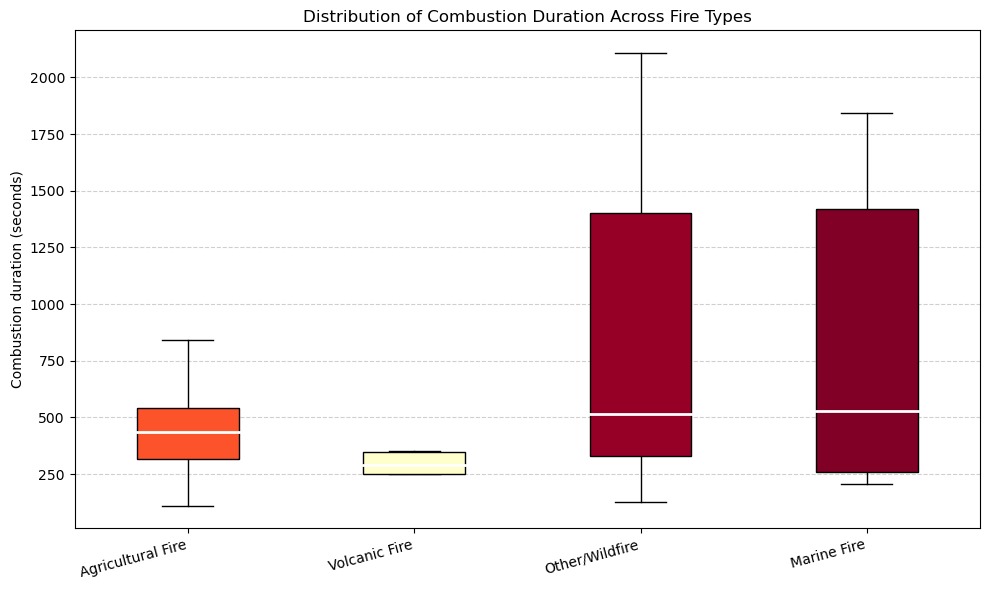


 Kruskal Wallis h test (overall difference in combustion duration):
  H = 11027.71, p = 0.0000e+00
There is a significant difference in the combustion duration of four types of fires (to be compared by two)

 Comparison of combustion duration (Mann Whitney U, Bonferroni correction α ≈ 0.0083):
  Agricultural Fire vs Volcanic Fire: p = 1.1670e-01 ❌
  Agricultural Fire vs Other/Wildfire: p = 0.0000e+00 ✅
The duration of Agricultural Fire is significantly shorter than that of Other/Wildfire
  Agricultural Fire vs Marine Fire: p = 2.9265e-18 ✅
The duration of Agricultural Fire is significantly shorter than that of Marine Fire
  Volcanic Fire vs Other/Wildfire: p = 2.0343e-02 ❌
  Volcanic Fire vs Marine Fire: p = 9.6384e-02 ❌
  Other/Wildfire vs Marine Fire: p = 1.1286e-01 ❌

Analyze time distribution (field:'acq_date')


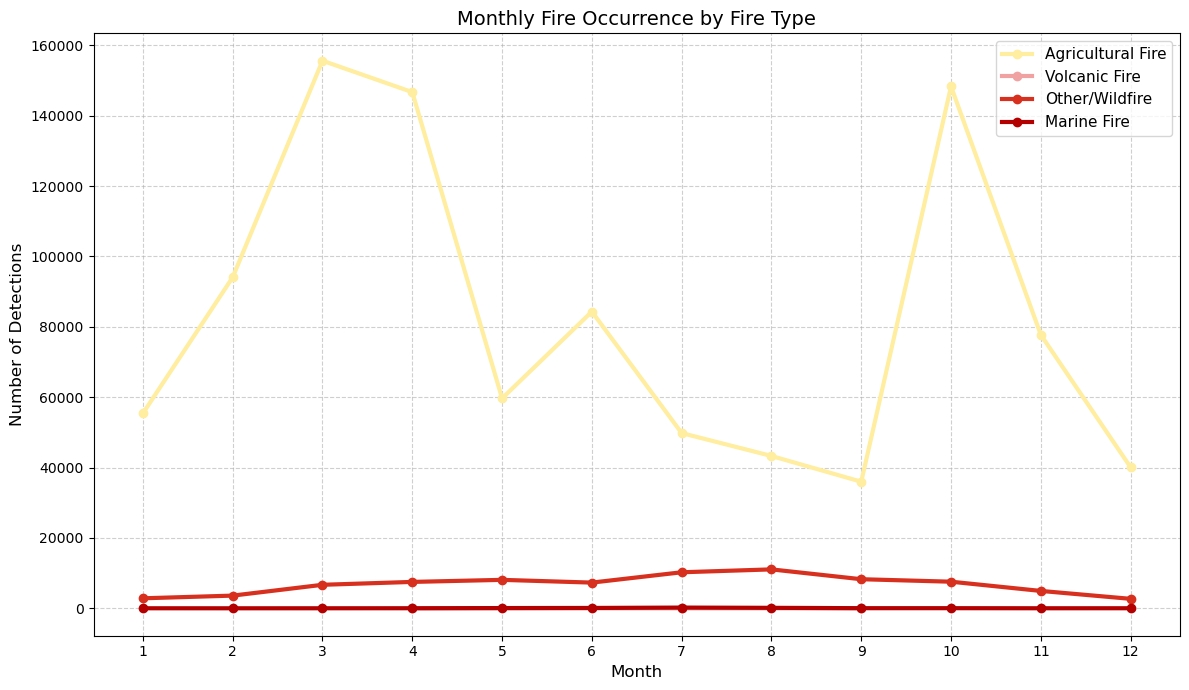

In [6]:
print("\n" + "="*80)
print(" Analyze the difference of acq_time (unit: s) in four types of fires")
print("="*80)

if 'acq_time' not in df_four.columns:
    print("警告：数据中未找到 'acq_time' 列！请检查列名。可用列：", df_four.columns.tolist())
else:
    df_duration = df_four[df_four['acq_time'] > 0].copy()
    print(f"\n Number of effective combustion duration records: {len(df_duration)}")
    
    if len(df_duration) == 0:
        print("没有有效的 acq_time 数据（>0）！跳过分析。")
    else:
        print("\n Statistical summary of combustion duration (according to four types of fire):")
        duration_summary = df_duration.groupby('fire_type')['acq_time'].agg(
            count='count',
            mean='mean',
            median='median',
            std='std',
            min='min',
            max='max'
        ).round(2)
        print(duration_summary)

plt.figure(figsize=(10, 6))
df_plot_dur = df_duration.copy()
df_plot_dur['type'] = pd.Categorical(df_plot_dur['type'], categories=[0,1,2,3])
df_plot_dur = df_plot_dur.sort_values('type')

medians_dur = [df_plot_dur[df_plot_dur['type'] == t]['acq_time'].median() for t in [0,1,2,3]]

norm = plt.Normalize(min(medians_dur), max(medians_dur))
colors = plt.cm.YlOrRd(norm(medians_dur))  

box_data_dur = [df_plot_dur[df_plot_dur['type'] == t]['acq_time'] for t in [0,1,2,3]]
labels_dur = [type_labels[t] for t in [0,1,2,3]]

box = plt.boxplot(box_data_dur, 
                 labels=labels_dur, 
                 showfliers=False, 
                 patch_artist=True)

for i, box_patch in enumerate(box['boxes']):
    box_patch.set(facecolor=colors[i])
    box_patch.set(edgecolor='black')

for median in box['medians']:
    median.set(color='white', linewidth=2)

plt.ylabel('Combustion duration (seconds)')
plt.title('Distribution of Combustion Duration Across Fire Types')
plt.xticks(rotation=15, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

duration_groups = [df_duration[df_duration['type'] == t]['acq_time'] for t in [0,1,2,3]]
h_stat_dur, p_val_global_dur = kruskal(*duration_groups)
        
print(f"\n Kruskal Wallis h test (overall difference in combustion duration):")
print(f"  H = {h_stat_dur:.2f}, p = {p_val_global_dur:.4e}")
if p_val_global_dur < 0.05:
    print("There is a significant difference in the combustion duration of four types of fires (to be compared by two)")
else:
    print("四类火灾燃烧持续时间无显著整体差异")

print("\n Comparison of combustion duration (Mann Whitney U, Bonferroni correction α ≈ {:.4f}):".format(alpha))
        
for t1, t2 in pairs:  
    group1 = df_duration[df_duration['type'] == t1]['acq_time']
    group2 = df_duration[df_duration['type'] == t2]['acq_time']
            
    if len(group1) == 0 or len(group2) == 0:
        print(f"  {type_labels[t1]} vs {type_labels[t2]}: 某组无数据")
        continue
                
    u, p = stats.mannwhitneyu(group1, group2, alternative='two-sided')
    sig = "✅" if p < alpha else "❌"
    print(f"  {type_labels[t1]} vs {type_labels[t2]}: p = {p:.4e} {sig}")
            
    if p < alpha:
        combined = np.concatenate([group1, group2])
        ranks = stats.rankdata(combined)
        r1 = ranks[:len(group1)].mean()   # group1 的平均秩
        r2 = ranks[len(group1):].mean()   # group2 的平均秩
        if r1 > r2:
            print(f"The duration of {type_labels[t1]} is significantly longer than that of {type_labels[t2]}")
        else:
            print(f"The duration of {type_labels[t1]} is significantly shorter than that of {type_labels[t2]}")
        
time_col = None
candidate_cols = ['acq_date', 'acqdate', 'date', 'datetime', 'time']
for col in candidate_cols:
    if col in df_clean.columns:
        time_col = col
        break

if time_col:
    print(f"\nAnalyze time distribution (field:'{time_col}')")
    df_clean[time_col] = pd.to_datetime(df_clean[time_col], errors='coerce')
    df_clean = df_clean.dropna(subset=[time_col])
    df_clean['month'] = df_clean[time_col].dt.month

    custom_colors = [
        '#FFEDA0',  
        '#F0A2A2', 
        '#D7301F',  
        '#B30000' 
    ]

    plt.figure(figsize=(12, 7))
    for i, t in enumerate([0,1,2,3]):
        subset = df_clean[df_clean['type'] == t]
        monthly = subset['month'].value_counts().sort_index()
        
        plt.plot(monthly.index.values, monthly.values, 
         marker='o', 
         label=type_labels[t],
         color=custom_colors[i],
         linewidth=3.0)

    plt.title('Monthly Fire Occurrence by Fire Type', fontsize=14)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Number of Detections', fontsize=12)
    plt.xticks(range(1,13), fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(fontsize=11, frameon=True, framealpha=0.8, loc='best')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print(f"\n 未找到时间字段。可用列名：{list(df_clean.columns)}")


Analysis: does agricultural fire dominate violent combustion events?
 Definition of severe combustion event: FRP>35.70 MW (top 10% overall)

 Total violent combustion events: 107255
Proportion of each type:
  Agricultural Fire: 103350  (96.4%)
  Volcanic Fire: 2  (0.0%)
  Other/Wildfire: 3810  (3.6%)
  Marine Fire: 93  (0.1%)

 Comparison of agricultural fire proportion:
  - In all fires: 92.4% (991135/1072841)
  - In severe fire: 96.4% (103350/107255)

 Agricultural fire is the main source of severe burning events (>50%)


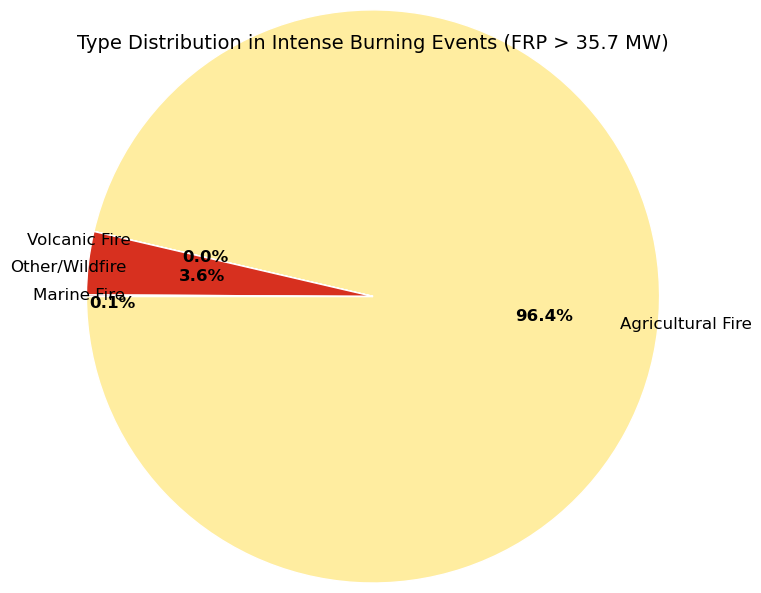

In [4]:
print("\n" + "="*80)
print("Analysis: does agricultural fire dominate violent combustion events?")
print("="*80)

if 'frp' not in df_clean.columns or len(df_clean) == 0:
    print("缺少有效 FRP 数据，跳过分析。")
else:
    threshold = df_clean['frp'].quantile(0.90) 
    print(f" Definition of severe combustion event: FRP>{threshold:.2f} MW (top 10% overall)")

    intense_fires = df_clean[df_clean['frp'] > threshold].copy()
    total_intense = len(intense_fires)
    
    if total_intense == 0:
        print(" 无剧烈燃烧事件！")
    else:
        intense_by_type = intense_fires['type'].value_counts()
        intense_pct = intense_by_type / total_intense * 100
        
        print(f"\n Total violent combustion events: {total_intense}")
        print("Proportion of each type:")
        for t in [0, 1, 2, 3]:
            ft = type_labels[t]  
            count = intense_by_type.get(t, 0)  
            pct = intense_pct.get(t, 0)  
            print(f"  {ft}: {count}  ({pct:.1f}%)")

        total_all = len(df_clean)
        agri_total = len(df_clean[df_clean['type'] == 0])
        agri_intense = len(intense_fires[intense_fires['type'] == 0])
        
        agri_total_pct = agri_total / total_all * 100
        agri_intense_pct = agri_intense / total_intense * 100
        
        print(f"\n Comparison of agricultural fire proportion:")
        print(f"  - In all fires: {agri_total_pct:.1f}% ({agri_total}/{total_all})")
        print(f"  - In severe fire: {agri_intense_pct:.1f}% ({agri_intense}/{total_intense})")
        
        if agri_intense_pct > 50:
            print("\n Agricultural fire is the main source of severe burning events (>50%)")
        elif agri_intense_pct > agri_total_pct:
            print(f"\n 农业火灾在剧烈事件中占比（{agri_intense_pct:.1f}%）高于其总体占比（{agri_total_pct:.1f}%），说明其更易产生剧烈燃烧。")
        else:
            print(f"\n 农业火灾在剧烈事件中占比较低（{agri_intense_pct:.1f}%），不是主要来源。")

        custom_colors = [
            '#FFEDA0',  
            '#F0A2A2',  
            '#D7301F',  
            '#B30000'  
        ]
        counts = [intense_by_type.get(t, 0) for t in [0,1,2,3]]
        valid_types = [t for t in [0,1,2,3] if counts[t] > 0]
        valid_counts = [counts[t] for t in valid_types]
        valid_labels = [type_labels[t] for t in valid_types]
        valid_colors = [custom_colors[t] for t in valid_types]
        
        explode = [0.0 if t == 0 else 0.15 for t in valid_types] 

        plt.figure(figsize=(8, 6))
        wedges, texts, autotexts = plt.pie(
            valid_counts, 
            labels=valid_labels, 
            autopct='%1.1f%%',  
            startangle=180,      
            colors=valid_colors,
            textprops={'fontsize': 12, 'color': 'black'}, 
            labeldistance=1.3,  
            radius=1.5,        
            wedgeprops={'edgecolor': 'white', 'linewidth': 1.0}
        )
        
        for autotext in autotexts:
            autotext.set_fontsize(12)
            autotext.set_weight('bold')
        
        for i, (wedge, text) in enumerate(zip(wedges, texts)):
            angle = (wedge.theta2 + wedge.theta1)/2
            radians = np.deg2rad(angle)
            x = 1.3 * np.cos(radians)
            y = 1.3 * np.sin(radians)
            text.set_position((x, y))
            
            autotext.set_position((x*1.05, y*-10))
        
        plt.title(f"Type Distribution in Intense Burning Events (FRP > {threshold:.1f} MW)", fontsize=14)
        plt.tight_layout()
        plt.show()